![title](../assets/problem.png)

In [1]:
import json
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import plotly.express as px
from typing import Dict, List, Union, Any
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 5000)
pd.set_option('max_colwidth', 5000)

In [3]:
BASE_PATH = "/Users/zhaocong/Desktop/belote-mlops-course/data"

PATH_TO_SYNTHETIC_DATA = f"{BASE_PATH}/synthetic_data_contract.csv"
PATH_TO_EXPLODED_FEATURES = f"{BASE_PATH}/exploded_features.csv"
PATH_TO_FEATURE_STORE = f"{BASE_PATH}/feature_store.csv"
PATH_TO_DEV_TRAINING_DATA = f"{BASE_PATH}/dev_training.csv"
PATH_TO_DEV_TESTING_DATA = f"{BASE_PATH}/dev_testing.csv"
PATH_TO_AUTOML_TRAINING_DATA = f"{BASE_PATH}/automl_training.csv"
PATH_TO_PRECISION_RECALL = f"{BASE_PATH}/precision_recall.csv"
PATH_TO_OPTIMAL_MODEL = f"{BASE_PATH}/optimal_model.pickle"
PATH_TO_PRODUCTION_MODEL = f"{BASE_PATH}/production_model.pickle"
PATH_TO_TRAINING_DATA = f"{BASE_PATH}/training.csv"
PATH_TO_EXPERIMENTATION_DATA = f"{BASE_PATH}/experimentation.csv"

# Table of Content:
* [Overview](#first-bullet)
* [Feature Engineering](#second-bullet)
* [Model Development](#third-bullet)
* [Model Training](#fourth-bullet)
* [Model Serving](#fifth-bullet)
* [Model Experimentation](#sixth-bullet)

# Model Development <a class="anchor" id="third-bullet"></a>

In [4]:
import pickle
from typing import Dict, List, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

### Import feature store

In [5]:
SAMPLE = 10000
feature_store = pd.read_csv(PATH_TO_FEATURE_STORE, nrows=SAMPLE)

In [6]:
feature_store.head()

,contract,reward,last_bidder,starter,p1_face_value,p2_face_value,has_x_cards_in_suit_clubs,has_x_cards_in_suit_diamonds,has_x_cards_in_suit_hearts,has_x_cards_in_suit_spades,has_x_sevens,has_x_eights,has_x_nines,has_x_tens,has_x_jacks,has_x_queens,has_x_kings,has_x_aces,has_BR_at_clubs,has_BR_at_diamonds,has_BR_at_hearts,has_BR_at_spades,has_tierce_at_clubs,has_tierce_at_diamonds,has_tierce_at_hearts,has_tierce_at_spades,total_BR_points,total_tierce_points,total_AnD_points,clubs,diamonds,hearts,sans_atouts,spades,tout_atouts,p1_has_won
0,tout_atouts,298,2,2,89,38,6,1,3,2,0,3,1,1,2,2,2,1,20,0,0,0,20,0,0,0,20,20,40,0,0,0,0,0,1,1
1,sans_atouts,-130,1,2,45,14,4,2,4,2,2,2,1,2,0,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,sans_atouts,10,1,1,58,31,4,3,4,1,2,1,0,1,2,1,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,spades,128,1,1,94,4,3,2,3,4,2,1,1,2,1,1,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,hearts,-18,2,2,60,14,3,5,2,2,1,2,2,1,0,2,2,2,0,0,0,0,0,20,0,0,0,20,20,0,0,1,0,0,0,0


In [7]:
TARGET = "p1_has_won"
SEGMENTS = ["reward", "contract"]
COVARIATES = list(filter(lambda covariate: covariate not in [TARGET], feature_store.columns))
BASE_THRESHOLD = 0.5
RANDOM_STATE = 42

### Split the training and validation sets

In [9]:
"""
Make sure to set a holdout frame on the side.
"""
(
    covariates_training,
    covariates_testing,
    target_training,
    target_testing,
) = train_test_split(
    feature_store[COVARIATES],
    feature_store[TARGET],
    test_size=0.25,
    random_state=RANDOM_STATE,
)

In [10]:
print(covariates_training.shape)
print(covariates_testing.shape)
print(target_training.shape)
print(target_testing.shape)

(7500, 35)
(2500, 35)
(7500,)
(2500,)


### Preserve the segments and ids 

In [11]:
segment_covariates_training = covariates_training[SEGMENTS]
covariates_training = covariates_training.drop(SEGMENTS, axis=1)

segment_covariates_testing = covariates_testing[SEGMENTS]
covariates_testing = covariates_testing.drop(SEGMENTS, axis=1)

In [13]:
COVARIATES = list(filter(lambda covariate: covariate not in ([TARGET] + SEGMENTS), feature_store.columns))

In [14]:
print(COVARIATES)

['last_bidder', 'starter', 'p1_face_value', 'p2_face_value', 'has_x_cards_in_suit_clubs', 'has_x_cards_in_suit_diamonds', 'has_x_cards_in_suit_hearts', 'has_x_cards_in_suit_spades', 'has_x_sevens', 'has_x_eights', 'has_x_nines', 'has_x_tens', 'has_x_jacks', 'has_x_queens', 'has_x_kings', 'has_x_aces', 'has_BR_at_clubs', 'has_BR_at_diamonds', 'has_BR_at_hearts', 'has_BR_at_spades', 'has_tierce_at_clubs', 'has_tierce_at_diamonds', 'has_tierce_at_hearts', 'has_tierce_at_spades', 'total_BR_points', 'total_tierce_points', 'total_AnD_points', 'clubs', 'diamonds', 'hearts', 'sans_atouts', 'spades', 'tout_atouts']


### Get a first feeling of Bias vs Variance

In [15]:

base_hypers = {
    "n_estimators": 5000,
}

def generate_scoring(model, training_cov, training_tar, testing_cov, testing_tar) -> Dict[str, float]:
    model.fit(
        training_cov[COVARIATES].values, training_tar.values.ravel()
    )
    predictions: np.array = model.predict_proba(testing_cov[COVARIATES])[:, 1]
    predictions: np.array = np.where(predictions > BASE_THRESHOLD, 1, 0)
    return {
        "accuracy_score": accuracy_score(testing_tar, predictions),
        "recall_score": recall_score(testing_tar, predictions),
        "precision_score": precision_score(testing_tar, predictions),
    }

pipeline = {
    "BaggingClassifier": BaggingClassifier(
        **{**base_hypers, **{"n_jobs": -1}}
    ),
    "GradientBoostingClassifier": GradientBoostingClassifier(
        **{**base_hypers, **{"max_depth": 5, "min_samples_split": 5, "min_samples_leaf": 5}}
    ),
    "RandomForestClassifier": RandomForestClassifier(
        **{**base_hypers, **{"max_depth": 5, "min_samples_split": 5, "min_samples_leaf": 5, "n_jobs": -1}}
    )
}


class ModelEvaluation:
    
    def __init__(self, name, model, metrics):
        self.name: str = name
        self.model: Any = model
        self.metrics: Dict[str, float] = metrics
        
    @property
    def accuracy_score(self):
        return self.metrics.get("accuracy_score")
    
    @property
    def recall_score(self):
        return self.metrics.get("recall_score")
    
    @property
    def precision_score(self):
        return self.metrics.get("precision_score")


metric_accumulators = []
for name, model in pipeline.items():
    metrics = generate_scoring(
        model, covariates_training, target_training, covariates_testing, target_testing
    )
    metric_accumulators.append(
        ModelEvaluation(name, model, metrics)
    )
    print(name, " - \n", metrics)

BaggingClassifier  - 
 {'accuracy_score': 0.764, 'recall_score': 0.7649880095923262, 'precision_score': 0.7637669592976856}
GradientBoostingClassifier  - 
 {'accuracy_score': 0.73, 'recall_score': 0.7242206235011991, 'precision_score': 0.7330097087378641}
RandomForestClassifier  - 
 {'accuracy_score': 0.7264, 'recall_score': 0.7513988808952837, 'precision_score': 0.715917745620716}


### Train the optimal hyperparameters

In [16]:
base_model = RandomForestClassifier()
hyperparameters_grid = {
    "n_estimators": [5000],
    "max_depth": [5],
    "min_samples_split": [5],
    "min_samples_leaf": [5],
}
random_search = RandomizedSearchCV(
    base_model,
    param_distributions=hyperparameters_grid,
    n_iter=1,
    scoring=None,
    n_jobs=-1,
    cv=2,
    verbose=1,
    refit=False,
)
random_search.fit(
    covariates_training[COVARIATES], target_training.values.reshape(-1, 1)
)
optimal_hyper_parameters, cv_results = random_search.best_params_, random_search.cv_results_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/anaconda3/envs/mlops/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/mlops/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


### Train the optimal model on the whole training set

In [25]:
optimal_hyper_parameters = {
    "n_estimators": 5000,
    "max_depth": 5,
    "min_samples_split": 5,
    "min_samples_leaf": 5
}
base_model = RandomForestClassifier(
    verbose=1,
    n_jobs=-1,
)
optimal_model = base_model.set_params(**optimal_hyper_parameters)
optimal_model.fit(
    covariates_training[COVARIATES].values, target_training.values.ravel()
)

with open(PATH_TO_OPTIMAL_MODEL, 'wb') as handle:
    pickle.dump(optimal_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

# covariates_training.to_csv(PATH_TO_DEV_TRAINING_DATA, index=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    5.1s finished


### Generate the predictions

In [26]:
predictions = optimal_model.predict_proba(covariates_testing[COVARIATES])[:, 1]
covariates_testing["predictions"] = predictions
covariates_testing["target"] = target_testing
covariates_testing["predicted"] = covariates_testing["predictions"].apply(
    lambda x: 1 if x > BASE_THRESHOLD else 0
)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:    0.7s finished


In [27]:
covariates_testing.head()

,last_bidder,starter,p1_face_value,p2_face_value,has_x_cards_in_suit_clubs,has_x_cards_in_suit_diamonds,has_x_cards_in_suit_hearts,has_x_cards_in_suit_spades,has_x_sevens,has_x_eights,has_x_nines,has_x_tens,has_x_jacks,has_x_queens,has_x_kings,has_x_aces,has_BR_at_clubs,has_BR_at_diamonds,has_BR_at_hearts,has_BR_at_spades,has_tierce_at_clubs,has_tierce_at_diamonds,has_tierce_at_hearts,has_tierce_at_spades,total_BR_points,total_tierce_points,total_AnD_points,clubs,diamonds,hearts,sans_atouts,spades,tout_atouts,predictions,target,predicted
6252,1,2,83,16,3,2,4,3,2,2,1,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.705362,1,1
4684,1,1,65,4,3,2,5,2,1,0,0,1,2,2,3,3,20,0,0,0,0,0,20,0,20,20,40,0,0,0,0,1,0,0.677986,1,1
1731,2,1,85,27,3,4,2,3,0,1,3,3,2,0,2,1,0,0,0,0,0,40,0,0,0,40,40,0,1,0,0,0,0,0.478312,1,0
4742,1,1,71,13,4,3,3,2,2,2,3,0,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.702750,1,1
4521,1,2,51,28,2,3,4,3,0,1,3,0,2,1,3,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.596068,1,1


### Generate the precision and recall metrics

In [28]:
precision_arr, recall_arr, threshold_arr = precision_recall_curve(
    target_testing, predictions
)
metrics_df = pd.DataFrame(
    {
        "precision": precision_arr[1:],
        "recall": recall_arr[1:],
        "threshold": threshold_arr,
    }
)
metrics_df["threshold"] = metrics_df["threshold"].apply(lambda x: round(x, 2))
metrics_df.drop_duplicates(subset=["threshold"], keep="first", inplace=True)
metrics_df.to_csv(PATH_TO_PRECISION_RECALL, index=False)

In [29]:
metrics_df.head()

,precision,recall,threshold
0,0.500600,1.0,0.22
4,0.501403,1.0,0.23
8,0.502208,1.0,0.24
20,0.504639,1.0,0.25
40,0.508743,1.0,0.26


ROC_AUC 0.8114590793338108
Accuracy 0.724


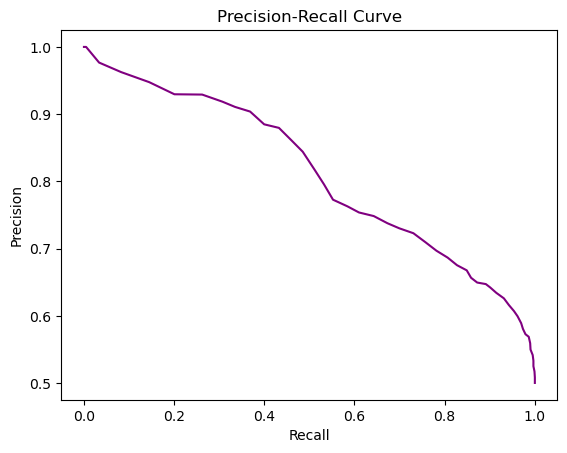

In [38]:
print("ROC_AUC", roc_auc_score(target_testing, predictions))
print("Accuracy", accuracy_score(target_testing, covariates_testing.predicted))
fig, ax = plt.subplots()
ax.plot(metrics_df["recall"].values, metrics_df["precision"].values, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

### Interpret the model

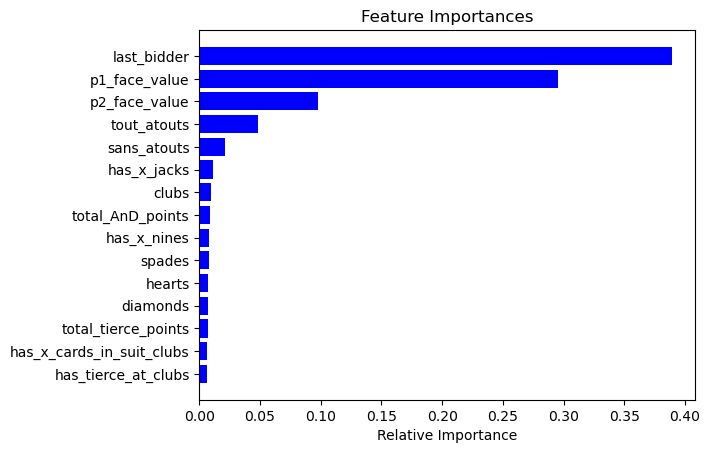

In [39]:
importances = optimal_model.feature_importances_
indices = np.argsort(importances)[-15:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [COVARIATES[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Study the errors

In [40]:
metrics_df[metrics_df.threshold == BASE_THRESHOLD]

,precision,recall,threshold
1165,0.709895,0.756994,0.5


In [45]:
metrics_df[metrics_df.precision > 0.9].head(1)

,precision,recall,threshold
1989,0.903922,0.368505,0.64


In [46]:
BUSINESS_THRESDHOLD = 0.65

covariates_testing["business_predicted"] = covariates_testing["predictions"].apply(
    lambda x: 1 if x > BUSINESS_THRESDHOLD else 0
)
covariates_testing = pd.concat([covariates_testing, segment_covariates_testing], axis=1)
#covariates_testing.to_csv(PATH_TO_DEV_TESTING_DATA, index=False)

In [47]:
errors = covariates_testing[covariates_testing.target != covariates_testing.predicted]

In [48]:
covariates_testing.describe()

,last_bidder,starter,p1_face_value,p2_face_value,has_x_cards_in_suit_clubs,has_x_cards_in_suit_diamonds,has_x_cards_in_suit_hearts,has_x_cards_in_suit_spades,has_x_sevens,has_x_eights,has_x_nines,has_x_tens,has_x_jacks,has_x_queens,has_x_kings,has_x_aces,has_BR_at_clubs,has_BR_at_diamonds,has_BR_at_hearts,has_BR_at_spades,has_tierce_at_clubs,has_tierce_at_diamonds,has_tierce_at_hearts,has_tierce_at_spades,total_BR_points,total_tierce_points,total_AnD_points,clubs,diamonds,hearts,sans_atouts,spades,tout_atouts,predictions,target,predicted,business_predicted,reward
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.00000,2500.00000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.0000,2500.000000,2500.000000,2500.000000
mean,1.441600,1.485200,66.568000,22.180800,3.021600,2.97600,2.977200,3.025200,1.467200,1.51920,1.48120,1.505600,1.51280,1.514800,1.524800,1.474400,1.568000,1.544000,1.392000,1.448000,1.43200,1.592000,1.456000,1.480000,5.952000,5.96000,11.912000,0.13040,0.126800,0.126000,0.170000,0.123200,0.323600,0.500313,0.5004,0.522000,0.177200,-12.326400
std,0.496677,0.499881,24.485024,12.177398,1.215617,1.23322,1.195848,1.215054,0.911952,0.90042,0.91191,0.901939,0.91508,0.906703,0.926136,0.933002,5.377076,5.339238,5.090452,5.184018,5.88245,6.056419,5.890156,5.760458,10.173254,11.05112,16.727707,0.33681,0.332815,0.331916,0.375708,0.328732,0.467943,0.132683,0.5001,0.499616,0.381914,141.984401
min,1.000000,1.000000,11.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221184,0.0000,0.000000,0.000000,-358.000000
25%,1.000000,1.000000,48.000000,14.000000,2.000000,2.00000,2.000000,2.000000,1.000000,1.00000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.392453,0.0000,0.000000,0.000000,-82.500000
50%,1.000000,1.000000,62.000000,21.000000,3.000000,3.00000,3.000000,3.000000,1.000000,1.00000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.506826,1.0000,1.000000,0.000000,2.000000
75%,2.000000,2.000000,83.000000,30.000000,4.000000,4.00000,4.000000,4.000000,2.000000,2.00000,2.00000,2.000000,2.00000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,20.000000,20.00000,20.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.612583,1.0000,1.000000,0.000000,66.000000
max,2.000000,2.000000,151.000000,74.000000,7.000000,7.00000,7.000000,6.000000,4.000000,4.00000,4.00000,4.000000,4.00000,4.000000,4.000000,4.000000,20.000000,20.000000,20.000000,20.000000,60.00000,40.000000,60.000000,40.000000,60.000000,60.00000,100.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.731944,1.0000,1.000000,1.000000,378.000000


In [49]:
covariates_testing.contract.value_counts(normalize=True)

tout_atouts    0.3236
sans_atouts    0.1700
clubs          0.1304
diamonds       0.1268
hearts         0.1260
spades         0.1232
Name: contract, dtype: float64

In [50]:
errors.describe()

,last_bidder,starter,p1_face_value,p2_face_value,has_x_cards_in_suit_clubs,has_x_cards_in_suit_diamonds,has_x_cards_in_suit_hearts,has_x_cards_in_suit_spades,has_x_sevens,has_x_eights,has_x_nines,has_x_tens,has_x_jacks,has_x_queens,has_x_kings,has_x_aces,has_BR_at_clubs,has_BR_at_diamonds,has_BR_at_hearts,has_BR_at_spades,has_tierce_at_clubs,has_tierce_at_diamonds,has_tierce_at_hearts,has_tierce_at_spades,total_BR_points,total_tierce_points,total_AnD_points,clubs,diamonds,hearts,sans_atouts,spades,tout_atouts,predictions,target,predicted,business_predicted,reward
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,1.414493,1.515942,70.260870,22.784058,2.988406,2.955072,2.972464,3.084058,1.468116,1.555072,1.517391,1.488406,1.421739,1.536232,1.513043,1.500000,1.565217,1.826087,1.623188,1.594203,1.449275,1.478261,1.739130,1.826087,6.608696,6.492754,13.101449,0.069565,0.073913,0.071014,0.253623,0.068116,0.463768,0.506123,0.460870,0.539130,0.055072,-41.568116
std,0.492992,0.500108,23.552463,12.240860,1.246130,1.234252,1.225324,1.261881,0.907794,0.911471,0.928731,0.867413,0.887155,0.897985,0.888879,0.930456,5.375530,5.765008,5.465558,5.420808,5.618589,5.962166,6.500312,6.248266,10.953414,11.385351,17.605700,0.254597,0.261819,0.257035,0.435400,0.252128,0.499047,0.091192,0.498828,0.498828,0.228287,205.765361
min,1.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.264564,0.000000,0.000000,0.000000,-358.000000
25%,1.000000,1.000000,50.000000,14.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.443115,0.000000,0.000000,0.000000,-258.000000
50%,1.000000,2.000000,67.500000,21.000000,3.000000,3.000000,3.000000,3.000000,1.000000,2.000000,1.000000,1.500000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.505729,0.000000,1.000000,0.000000,-73.000000
75%,2.000000,2.000000,89.000000,31.000000,4.000000,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,20.000000,20.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.574610,1.000000,1.000000,0.000000,150.000000
max,2.000000,2.000000,133.000000,68.000000,6.000000,6.000000,7.000000,6.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,20.000000,20.000000,20.000000,20.000000,40.000000,40.000000,60.000000,40.000000,60.000000,60.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.713898,1.000000,1.000000,1.000000,378.000000


In [51]:
errors.contract.value_counts(normalize=True)

tout_atouts    0.463768
sans_atouts    0.253623
diamonds       0.073913
hearts         0.071014
clubs          0.069565
spades         0.068116
Name: contract, dtype: float64

### [Optional] Assignment 3 - Google Cloud Engine Lab

Let's head over to Google Cloud Engine to set up a larger VM.
This will allow us to run larger development pipelines such as:

- Large scale grid search (Bayesian, Random or Grid)
- Tuning over subset of models (Boosters, Trees and NN)

First, make sure to set up you <a> Google Cloud Storage </a> bucket that we will use throughout this course.

Then, follow this lab to set up your <a> Google Cloud VM </a> server and launch a first E2E model development run.

### [Optional] Assignment 4 - Google AutoML (Vertex) Lab

Let's head over to <a> Google Cloud Vertex AI </a> to launch automated training pipelines at scale.

We will essentially replicate the workflow we have set up here - but most of it will be abstracted from us through this complete, no-code solution.

In [ ]:
feature_store = pd.read_csv(PATH_TO_FEATURE_STORE)
feature_store[COVARIATES + [TARGET]].to_csv(PATH_TO_AUTOML_TRAINING_DATA, index=False)

#### Credit

Note:
This content has been developed by Sean Ariel for educational purposes. 
It is a practical training that cannot be copied, reproduced, distributed without the explicit consent from the author. © Sean Ariel